In [1]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python
# coding: utf-8
import requests
import pandas as pd
#import datetime
import time
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

def getData(ticker, metric, no_of_days):
    
    ticker = ticker + str('.NS')
    current_time = int(round(time.time()))
    start_time = current_time - (no_of_days)*24*60*60
    
    
    resp = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/'
                        +ticker+'?formatted=true&crumb=3fOAXVz3HoU&lang=en-IN&region=IN&period1='
                        +str(start_time)+'&period2='+str(current_time)
                        +'&interval=1d&events=div%7Csplit&corsDomain=in.finance.yahoo.com')
    
    
    result = resp.json()
    
    
    timestamps = result['chart']['result'][0]['timestamp']
    values = result['chart']['result'][0]['indicators']['quote'][0][metric]
    
    #len(values)
    #datetime.datetime.fromtimestamp(timestamps[len(timestamps) - 1])
    
    
    d = {'timestamp': timestamps, 'value': values}
    dataFrame = pd.DataFrame(data=d)
    
    #convert 9:15 to 3:30
    dataFrame['timestamp'] = dataFrame['timestamp'] + 375*60
    
    return dataFrame

def smoothen(values, window_len):
    x = values
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    w=eval('np.'+'hanning'+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def getMinimas(smv):
    localMin = argrelextrema(smv, np.less)
    points = [np.min(smv)]*(len(smv))
    
    for i in range(0,len(localMin[0])):
        points[localMin[0][i]] = smv[localMin[0][i]]
    
    return points

def getMaximas(smv):
    localMax = argrelextrema(smv, np.greater)
    points = [np.max(smv)]*(len(smv))
    
    for i in range(0,len(localMax[0])):
        points[localMax[0][i]] = smv[localMax[0][i]]
    
    return points

def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI')
    df = df.join(RSI)
    return df

In [7]:
df = pd.DataFrame()
window_len = 10
rsi_window = 10
equity = 'SBIN'
days = 365

df['Close'] = getData(equity, 'close', days)['value']
df['High'] = getData(equity, 'high', days)['value']
df['Low'] = getData(equity, 'low', days)['value']
df['Smooth'] = smoothen(df['Close'], window_len)[int(window_len/2):len(df['Close']) + int(window_len/2)]
df = relative_strength_index(df,rsi_window)

df = df.iloc[rsi_window:]
df['SmoothRSI'] = smoothen(df['RSI'], window_len)[int(window_len/2):len(df['RSI']) + int(window_len/2)]

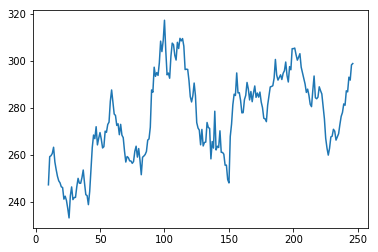

In [8]:
plt.plot(df['Close'])

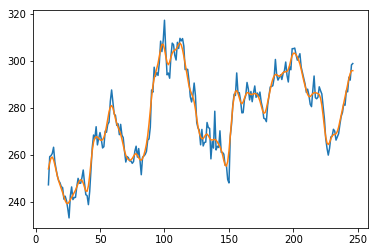

In [9]:
plt.plot(df['Close'])
plt.plot(df['Smooth'])

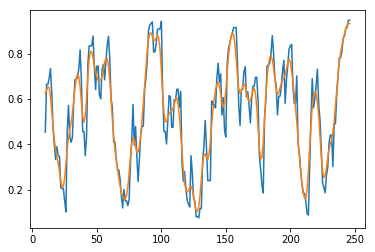

In [11]:
plt.plot(df['RSI'])
plt.plot(df['SmoothRSI'])

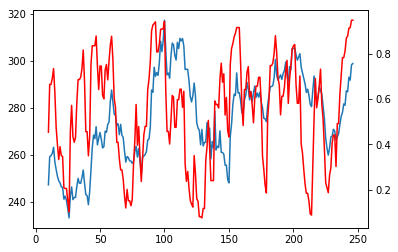

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df['Close'])
ax2.plot(df['RSI'],'r')

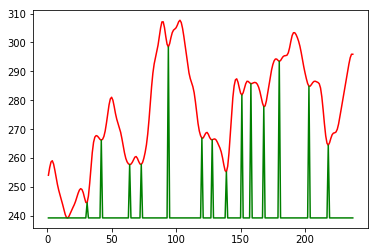

In [10]:
values = df['Close'].values
smv = df['Smooth'].values
xvalues = np.arange(1,len(smv) + 1)
plt.plot(xvalues, smv, 'r')
plt.plot(xvalues, getMinimas(smv), 'g')
#plt.plot(xvalues, getMaximas(smv), 'b')

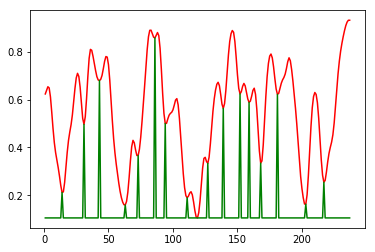

In [13]:
values = df['RSI'].values
smv = df['SmoothRSI'].values
xvalues = np.arange(1,len(smv) + 1)
plt.plot(xvalues, smv, 'r')
plt.plot(xvalues, getMinimas(smv), 'g')
#plt.plot(xvalues, getMaximas(smv), 'b')

In [14]:
len(df['Close']) - len(df['Smooth'])

0

In [15]:
m = getMinimas(df['SmoothRSI'].values)
mr = np.where(m != m[0])[0]
mr

array([ 13,  30,  42,  62,  72,  85,  93, 110, 126, 138, 151, 158, 167,
       180, 202, 216])

In [16]:
m = getMinimas(df['Smooth'].values)
mv = np.where(m != m[0])[0]
mv

array([ 30,  41,  63,  72,  93, 119, 127, 138, 150, 157, 167, 179, 202,
       217])

In [17]:
m = getMaximas(df['SmoothRSI'].values)
np.where(m != m[0])

(array([  2,  25,  35,  47,  68,  82,  87, 102, 113, 124, 134, 145, 154,
        162, 175, 189, 209]),)

In [18]:
m = getMaximas(df['Smooth'].values)
np.where(m != m[0])

(array([  3,  25,  37,  49,  68,  89, 123, 129, 146, 154, 160, 176, 191,
        207]),)

In [19]:
points = dict()
for a in mr:
    if (a + 1) in mv:
        points[a] = a+1
    elif (a + 2) in mv:
        points[a] = a+2
    elif (a - 1) in mv:
        points[a] = a-1
    if (a - 2) in mv:
        points[a] = a-2
    elif a in mv:
        points[a] = a

In [20]:
prev = -1
for i in points.keys():
    if prev != -1:
        current_close = df['Close'].values[points[i]]
        previous_close = df['Close'].values[points[prev]]
        
        current_rsi_close = df['RSI'].values[i]
        previous_rsi_close = df['RSI'].values[prev]
        
        if current_close < previous_close and current_rsi_close > previous_rsi_close:
            print(points[i])
            
    prev = i
        
    

72
138
217
